

### О задании
На сайтах для поиска работы можно найти сотни тысяч объявлений, каждое из которых состоит из пространного описания вакансии и предлагаемой зарплаты. Есть ли связь между описанием и зарплатой? Существуют ли определенные слова, которые наиболее сильно характеризуют зарплату? Можно ли найти другие информативные факторы? Вам предстоит ответить на эти вопросы, проанализировав выборку объявлений о работе в Великобритании.

Практическое задание 2 посвящено работе с текстовыми данными и категориальными признаками и задачам бинарной классификации. Вы научитесь:
 * работать с категориальными признаками;
 * строить вещественные представления текстовых данных;
 * обучать и строить прогнозы линейных классификаторов при помощи scikit-learn и Vowpal Wabbit;
 * тестировать модели и проводить оценку качества в задачах бинарной классификации.


### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Кроме того, некоторые из заданий являются опциональными (необязательными), однако за их выполнение можно получить дополнительные баллы, которые позднее будут учитываться при проставлении оценок автоматом по курсу.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Данные

Как было упомянуто ранее, в рамках данного задания мы будем решать задачу бинарной классификации для предсказания уровня заработной платы по тексту объявления о вакансии на примере набора данных с соревнования [Adzuna - Job Salary Prediction](https://www.kaggle.com/c/job-salary-prediction). Для начала пройдите по [ссылке](https://www.kaggle.com/c/job-salary-prediction/data) и скачайте файл Train_rev1 (при необходимости, зарегистрируйтесь на Kaggle).

Посмотрим на данные в файле и загрузим их в DataFrame:

In [2]:
%pylab inline

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
# print first 2 rows from Train_rev1.csv
!head -n 2 Train_rev1.csv

# Как видно, первая строка - название столбцов
# Вторая строка - первая строка с данными

In [4]:
# Читаем csv, преобразовывая его в формат dataframe (формат библиотеки pandas)
# с помощью разделения по запятой

df = pd.read_csv('Train_rev1.csv', sep=',')
print(df.shape) # Смотрим на размер датафрейма, у него 12 столбцов и 244768 строк
df.head() # По умолчанию выводятся первые 5 строк датафрейма

(244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


В оригинальной постановке предлагается рассматривать признак SalaryNormalized как целевой и решать задачу регрессии, однако в рамках данного задания мы сведём её к задаче бинарной классификации, разделив объекты на 2 группы: объявления о вакансиях с низкой и высокой зарплатами соответственно.

<img src = "http://salt.uaa.alaska.edu/kath/kti/mean_median2.gif">

В качестве порога разбиения объектов на группы будем рассматривать медиану признака SalaryNormalized. Заметим, что таким образом мы автоматически получим задачу классификации со сбалансированными классами:

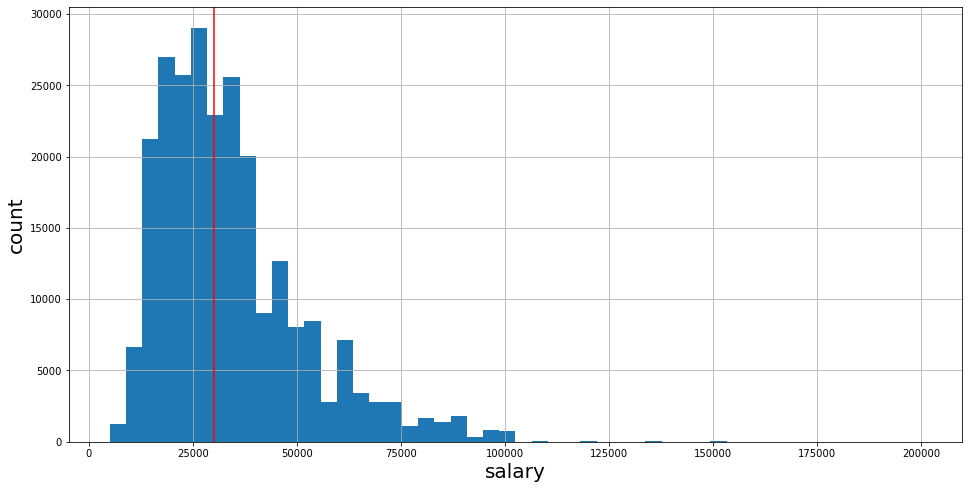

In [5]:
# salary histogramm
median = np.median(df['SalaryNormalized']) # находим медиану

# размер рисуемых прямоугольников
figsize(16, 8)
# формирование гистограммы по столбцу SalaryNormalized
# 50 - количество ячеек одинаковой ширины в диапазоне (??)
plt.hist(df['SalaryNormalized'], bins=50)
# добавляем вертикальную линию - медиану, красного цвета
plt.axvline(median, c='r')
# х-ось называем зарплата
plt.xlabel('salary', fontsize=20)
# у-ось называем количество (таких зарплат)
plt.ylabel('count', fontsize=20)
# рисуем настроенный график
plt.grid()

Осуществим последние шаги по подготовке датасета:
- бинаризуем признак SalaryNomalized по описанному ранее порогу;
- исключим из выборки признак SalaryRaw, чтобы устранить утечку целевой переменной в признаки.

In [6]:
# astype - Cast a pandas object to a specified dtype dtype.
# df['SalaryNormalized'] - вектор признака (все значения этой колонки)
# Порог - медиана. Если очередное значение больше медианы, то делаем его 1 (и он будет int)
# В итоге получается бинаризированная колонка этого признака
df['SalaryNormalized'] = (df['SalaryNormalized'] > median).astype(int)

# Удаляем это, потому что это почти то же самое, что SalaryNormalized
df.drop('SalaryRaw', axis=1, inplace=True)

print(df.shape) # теперь колонок 11
df.head()

(244768, 11)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk


#### 1. (0 баллов) Разбейте получившуюся выборку на обучающую и контрольную в соотношении 70/30 с использованием перемешивания объектов.

При разбиении используйте значение параметра random_state=42.

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, random_state = 42, test_size=0.3)

In [8]:
# Видно, что выборка разделилась на 70 и 30 процентов
print(len(train), len(test), len(train)/float(len(df)), len(test)/float(len(df)))
# А тут видно, что оно действительно разделилось
print(len(train) + len(test) == len(df))

171337 73431 0.6999975486991764 0.30000245130082365
True


In [9]:
train.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName
241453,72676065,Business Development Executive ****k plus bonus,Business Development Executive Dudley Permanen...,"Dudley, West Midlands (County) West Midlands (...",UK,NaN,permanent,Anderson Scott Solutions,Sales Jobs,0,totaljobs.com
169520,71341050,English Teacher,"English Teacher Permanent, Fulltime contract ...",Avon,Avon,full_time,contract,ITN Mark Education Bristol,Teaching Jobs,0,jobsineducation.co.uk
136661,70336585,EMEA Customer Service Project Coordinator,Excellent opportunity to join a successful glo...,Oxford,Oxford,full_time,NaN,Bluestream Recruitment,Customer Services Jobs,0,careerbuilder.com
125435,69992269,Administrator / Receptionist,Acting as a recruitment business on behalf of ...,Leeds West Yorkshire Yorkshire,Leeds,NaN,contract,Taskmaster,Admin Jobs,0,totaljobs.com
192568,71760157,Business Analyst / Product Owner to ****k,Business Analyst / Product Owner This is an ex...,London South East,South East London,NaN,permanent,The Industry Club,IT Jobs,1,cwjobs.co.uk


In [10]:
test.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName
30390,68062598,Business Account Manager,Business Account Manager Plumbing Heating Pro...,South West,South West London,NaN,permanent,BMS Sales Specialists,Sales Jobs,0,totaljobs.com
108709,69622111,Staff Nurse RGN/RMN Newtown Abbey Nights Ne...,Job Title; Staff Nurse RGN/RMN – NightsLocatio...,Newtownabbey,Newtownabbey,full_time,NaN,Regional Recruitment Services,Healthcare & Nursing Jobs,0,staffnurse.com
13924,66664026,Community Fundraising Manager,This dynamic international development charity...,London,London,full_time,permanent,TPP Not for Profit,Charity & Voluntary Jobs,1,Third Sector Jobs
154606,71015241,Conveyancing Executive,Large regional law firm require a residential ...,Hampshire,Hampshire,full_time,permanent,PTP Consulting,Legal Jobs,0,TotallyLegal
172891,71428553,Investment Compliance Analyst,This individual will work closely with the bus...,London South East,South East London,NaN,permanent,Michael Page Financial Services,Accounting & Finance Jobs,1,totaljobs.com


## Векторизация

Как правило, модели, используемые в машинном обучении, применяются в предположении, что матрица "объект-признак" является вещественнозначной. Поэтому при работе с категориальными признаками и текстами сперва их необходимо привести к вещественному виду.

Заметим, что в нашей задаче есть признаки, являющиеся текстами произвольной природы (Title, FullDescription), и категориальные признаки, принимающие ограниченное число значений (ContractType, Category и др.).

Самый простой и понятный способ преобразования текстовых данных — векторизация. В этом случае для каждого слова, встречающегося в некотором набре текстов мы создаём отдельный новый признак, который будет равен $1$, когда слово встречается в заданном объекте, и $0$ – в противном случае.

#### 2. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, осуществив векторизацию получившихся текстов при помощи [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [11]:
# Колонки - это признаки, строки - это объекты

In [12]:
# Не проходит по производительности и всё падает:(

# # "объединив значения всех признаков каждого объекта выборки через символы пробела"
# # Создадим функцию, которая будет соединять всё в колонке (признаке) с помощью пробела.
# def merge_words_in_column(column_name):
#     vector = df[column_name] # вектор очередного признака
#     return " ".join(str(x) for x in vector)

# def merge_columns(df):
#     text = ""
#     for column_name in df:
#         text = text + " " + merge_words_in_column(column_name)
#     return text

In [13]:
# Частично взято отсюда
# https://stackoverflow.com/questions/11858472/string-concatenation-of-two-pandas-columns
def merge_columns(df):
    return df.apply(lambda x: ' '.join(str(x)), axis=1)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

# соединяем слова для словарика (с помощью обучающей выборки)
vector_str = merge_columns(train)
# собираем словарик
vectorizer.fit(vector_str)

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
# векторизируем train с помощью нашего словарика (обучаем)
vector_train = vectorizer.transform(merge_columns(train))
# векторизируем test с помощью нашего словарика (применяем)
vector_test = vectorizer.transform(merge_columns(test))

# выводим всякую информацию
print(vector_test.shape)
# сегодня без просмотров, потому что нет вычислительных мощностей (246 гб оперативки)
# print(vector_test.toarray())

#### 3. (1.5 балла) Обучите следующие модели на обучающей выборке:
 - [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
 - логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

<div style="color:red">Модуль sklearn</div>

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
lr_prediction1 = logreg.fit(vector_train, train).predict(vector_train)

<div style="color:red">
Vowpal Wabbit
</div>

In [ ]:
import datetime
from datetime import datetime
import numpy as np

def get_label(tipo):
 labels={'Class_1':1,'Class_2':2,'Class_3':3,'Class_4':4,'Class_5':5,'Class_6':6,'Class_7':7,'Class_8':8,'Class_9':9}
 label=labels[tipo]
 return label
def csv_to_vw(loc_csv, loc_output, train=True):
    start = datetime.now()
    col_train=['id','target']
    col_test=['id']
    for k in range(1,94):
        col_train.append(str(k))
        col_test.append(str(k))
    
    print("\nTurning %s into %s. Is_train_set? %s"%(loc_csv,loc_output,train))
    i = open(loc_csv, "r")
    j = open(loc_output, 'wb')
    counter=0
    with i as infile:
        line_count=0
        for line in infile:
            # to counter the header
            if line_count==0:
                line_count=1
                continue
        
            categorical_features = ""
            counter = counter+1
    
            line = line.split(",")
            if train:
                col=col_train
                for i in range(2,95):
                    if line[1] != "":
                        categorical_features += "|feat_%s %s" % (col[i],line[i-1])
                categorical_features+='\n'        
            else:
                col=col_test
                for i in range(1,94):
                    if line[i] != "":
                        categorical_features += "|feat_%s %s" % (col[i],line[i])
               
             
            if train: #we care about labels
                
                label=get_label(line[94].rstrip('\n'))
               
                j.write( "%s '%s %s" % (label,line[0],categorical_features))

            else: #we dont care about labels
                j.write("1 '%s %s" % (line[0],categorical_features) )

        #Reporting progress
            #print counter
            if counter % 1000== 0:
                print("%s\t%s"%(counter, str(datetime.now() - start)))

    print("\n %s Task execution time:\n\t%s"%(counter, str(datetime.now() - start)))

csv_to_vw("path_to_yourdata/train.csv", "./train.vw",train=True)
csv_to_vw("path_to_yourdata/test.csv", "./test.vw",train=False)

In [ ]:
# convert a dataframe into VW format
# Скопировано отсюда:
# https://gallery.azure.ai/Experiment/Step-1-Convert-Dataset-to-VW-Format-1
# Колонки 'FullDescription', 'LocationRaw' не так уж и нужны

import pandas as pd
import numpy as np

def azureml_main(inputDF):
    labelColName = 'SalaryNormalized'
    trueLabel = 'SalaryNormalized'
    colsToExclude = ['FullDescription', 'LocationRaw']
    numericCols = ['fnlwgt']

    output = convertDataFrameToVWFormat(inputDF, labelColName, trueLabel, colsToExclude, numericCols)
    return output

def convertDataFrameToVWFormat(inputDF, labelColName, trueLabel, colsToExclude, numericCols):    
    # remove '|' and ':' that are special characters in VW
    def clean(s):
        return "".join(s.split()).replace("|", "").replace(":", "")

    def parseRow(row):
        line = []
        # convert labels to 1s and -1s and add to the beginning of the line        
        line.append("{} |".format('1' if row[labelColName] == trueLabel else '-1'))    

        for colName in featureCols:            
            if (colName in numericCols):
                # format numeric features
                line.append("{}:{}".format(colName, row[colName])) 
            else:
                # format string features
                line.append(clean(str(row[colName])))

        vw_line = " ".join(line)
        return vw_line

    # drop columns we don't need
    inputDF.drop(colsToExclude, axis = 1)

    # select feature columns
    featureCols = [c for c in inputDF.columns if c != labelColName]

    # parse each row                
    output = inputDF.apply(parseRow , axis = 1).to_frame()    
    return output

In [ ]:
# Конвертируем тестовый датафрейм в vw формат
test_vw = azureml_main(test)
print test_vw

In [ ]:
# Конвертируем тренировочный датафрейм в vw формат
train_vw = azureml_main(train)
print train_vw

<div style="color: red">
Нужно установить на компьютер Vowpal Wabbit
    
-d - data file<br />
-f - final model
</div>

In [ ]:
# Я не знаю, как поместить файл vw в эту команду
vw -d test_vw -f test_res.vw --loss_function logistic

In [ ]:
# Тут тоже не знаю
vw -d train_vw -f train_res.vw --loss_function logistic

#### 4. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 3 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [ ]:
# ROC - кривая
# AUC - площадь под кривой
# F-мера - показатель качества, среднее между точностью и полнотой 
# (а еще есть специфичность, Коэффициент Мэттьюса и другое)

In [ ]:
from sklearn.metrics import roc_curve as roc, auc, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
# ROC-AUC
r_x, r_y, _ = roc(test, lr_prediction1)
plt.plot(r_x, r_y)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=0)
plt.title("ROC-AUC")
plt.show()

In [ ]:
# Матрица ошибок
plot_confusion_matrix(confusion_matrix(lr_prediction1, test), show_absolute=True, show_normed=True, colorbar=True)
plt.title("Матрица ошибок")
plt.show()

In [ ]:
print(classification_report(test, lr_prediction1))

#### 5. (1 балл) Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 2. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретируйте полученный результат.

In [ ]:
from sklearn.feature_selection import SelectFromModel

def sort_weights(rows, columns, num):
    selector = SelectFromModel(estimator=LogisticRegression()).fit(rows, columns)
    d = {} 
    for i in range(len(selector.estimator_.coef_[0])):
        d[i] = selector.estimator_.coef_[0][i]
    sort_selector = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    reverse_vectorizer = dict(zip(vectorizer.vocabulary_.values(), vectorizer.vocabulary_.keys()))
    for i in range(num):
        print(reverse_vectorizer[list(sort_selector.keys())[i]], " \t\t", sort_selector[list(sort_selector.keys())[i]])

In [ ]:
sort_weights(vector_train, train, 100)

#### 6. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 2 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [ ]:
# Your code here

## TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:
$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D).$

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.

#### 7. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, вычислив вектор tf-idf для каждого объекта помощи [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [ ]:
# слова для словарика у нас уже есть в vector_str
# делаем то же самое, что при векторизации, только другой векторайзер

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer  = TfidfVectorizer()

vectorizer.fit(vector_str)
vector2_train = vectorizer.transform(merge_columns(train))
vector2_test = vectorizer.transform(merge_columns(test))
print(vector2_test.shape)

#### 8. (0 баллов) Обучите следующие модели на обучающей выборке:
- [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
- логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [ ]:
# то же самое, только подставляем другую переменную на выход:)
# logreg надо еще раз объявить, старая испорчена!

logreg = LogisticRegression(max_iter=1000)
lr_prediction2 = logreg.fit(vector2_train, train).predict(vector2_test)

#### 9. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 8 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [ ]:
# ROC-AUC
r_x, r_y, _ = roc(test, lr_prediction2)
plt.plot(r_x, r_y)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=0)
plt.title("ROC-AUC")
plt.show()

In [ ]:
# Матрица ошибок
plot_confusion_matrix(confusion_matrix(lr_prediction2, test), show_absolute=True, show_normed=True, colorbar=True)
plt.title("Матрица ошибок")
plt.show()

In [ ]:
print(classification_report(test, lr_prediction2))

#### 10. (0.5 балла) Сравните значения метрик из п. 9 со значениями, полученными в п. 5, и сравните соответствующие модели по качеству из работы.

**Ответ**:

#### 11. (1 балл) Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 8. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [ ]:
sort_weights(X_train2, y_train, 100)

#### 12. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 8 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [ ]:
# Your code here

## Счётчики

Ранее в рамках данного задания при построении моделей мы объединяли значения всех признаков в единую строку, что предполагает равноправность всех признаков. Однако заметим, что в этом случае мы допускаем потерю информации: слово "Glasgow" может по-разному влиять на зарплату, если оно находится в названии объявления и в геолокации. Чтобы устранить этот недостаток, при создании текстового описания объекта будем объединять только значения признаков Title и FullDescription, а остальные будем рассматривать как категориальные. При этом с полученным текстовым описанием объекта будем работать, как раньше (при помощи векторизации или tf-idf), а для кодирования категориальных признаков используем **счётчики**.

Идея этого метода состоит в том, чтобы заменить значение категориального признака на вероятность того, что объект с данным значением признака относится к положительному классу. Опишем эту идею более формально. Пусть у нас есть выборка $X = \{ (x_i, y_i) \}_{i=1}^l,$ и $j$-ый признак принимает значения из множества $U_j = \{ u_{jn}\}_{n=1}^{N_j},$ где $N_j$ — количество различных значений $j$-ого признака. Пусть $x_{ij} = u_{jn},$ тогда заменим значения $j$-ого категориального признака объекта $x_i$ на следующую оценку: 
$$\hat{P}(y_i=+1|x_{ij}=u_{jn}) = \frac{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right]}.$$

Однако заметим, что при таком способе формирования счётчиков мы учитываем в формуле для объекта $x_i$ его метку $y_i$, тем самым вносим информацию об ответе в признаки. Чтобы устранить этот недостаток, при вычислении счётчика будем исключать из рассмотрения текущий объект, т.е. рассматривать следующую оценку:
$$\hat{P}(y_i=+1|X_{ij}=u_{jn}) = \frac{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right]},$$

#### 13. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения признаков Title и FullDescription каждого объекта выборки через символ пробела, после чего перейдите к признаковому описанию объектов, вычислив вектор tf-idf аналогично п. 7.

In [ ]:
# Your code here

#### 14. (1 балл) Закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

In [ ]:
# Your code here

#### 15. (2 балла) Для выборки, полученной в п. 13, закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи счётчиков, после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

Уделите внимание оптимальности вычисления счётчиков!

In [ ]:
# Your code here

#### 16. (0.5 балла) Сравните значения метрик из п. 15 со значениями, полученными в п. 14, и сделайте вывод о качестве классификации для каждого из методов кодирования категориальных признаков.

**Ответ:**

## Подбор гиперпараметров

#### 17. (1.5 доп. балла) Разбейте обучающую выборку, полученную в п. 13, на обучающую и валидационную в отношении 80/20, после чего подберите оптимальное количество фолдов, используемое при кодировании категориальных признаков (всех, кроме Title и FullDescription), путём оптимизации значения accuracy на валидационной выборке. Используйте следующие модели, аналогично также подобрав оптимальные значения указанных гиперпараметров:
- логистическую регрессию из модуля sklearn с подбором коэффициента регуляризации;
- логистическую регрессию при помощи Vowpal Wabbit с подбором следующих гиперпараметров:
    - коэффициент регуляризации (--l2);
    - количество эпох (--passes);
    - длина градиентного шага (-l);
    - длина N-грамм (--ngram).

In [ ]:
# Your code here

#### 18. (0.5 доп. балла) Обучите указанные выше модели на обучающей выборке для оптимальных значений гиперпараметров, найденных в п. 17, после чего для каждой из моделей вычислите значения ROC-AUC, F-меры, а также постройте матрицу ошибок на контрольной выборке. Как качество классификации при помощи полученных в данном разделе моделей соотносится с моделями, полученными в предыдущих разделах?

In [ ]:
# Your code here

Здесь вы можете поделиться своими мыслями по поводу этого задания.

А здесь — вставить вашу вторую любимую смешную картинку.

In [16]:
from IPython.display import Image 
from IPython.core.display import HTML
 
Image(url= "image.jpg", width=300) 

А здесь — посоветовать преподавателям хороший фильм или сериал.

`Лобстер`